In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import label_binarize


# Define paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive 2"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model using pre-trained DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpointdense.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics (Precision, Recall, F1-Score, ROC AUC)
from sklearn.preprocessing import label_binarize


# Custom callback to calculate additional metrics
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        cm = confusion_matrix(val_labels, val_preds)
        TN = np.diag(cm).sum() - np.trace(cm)
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        specificity = np.mean(TN / (TN + FP + np.finfo(float).eps))
        sensitivity = np.mean(TP / (TP + FN + np.finfo(float).eps))

        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list, self.sensitivity_list, self.specificity_list = [], [], [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)
        self.sensitivity_list.append(sensitivity)
        self.specificity_list.append(specificity)

metrics_callback = MetricsCallback()

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]
)

# Save the final model
model.save('best_model_densenet.h5')

# Plotting
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(metrics_callback.sensitivity_list, label='Sensitivity')
plt.title('Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(metrics_callback.specificity_list, label='Specificity')
plt.title('Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7837 - loss: 0.6450

KeyboardInterrupt: 

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step
Epoch 1: Precision: 0.1576, Recall: 0.1640, F1-Score: 0.1524, ROC AUC: 0.4984
281/281 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.2797 - loss: 1.6856 - val_accuracy: 0.5047 - val_loss: 1.3894
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Epoch 2: Precision: 0.1759, Recall: 0.1740, F1-Score: 0.1555, ROC AUC: 0.5044
281/281 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.4402 - loss: 1.4014 - val_accuracy: 0.5000 - val_loss: 1.2612
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
Epoch 3: Precision: 0.1557, Recall: 0.1637, F1-Score: 0.1355, ROC AUC: 0.4982
281/281 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.4982 - loss: 1.2756 - val_accuracy: 0.4793 - val_loss: 1.2168
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step
Epoch 4: Precision: 0.1601, Recall: 0.1600, F1-Score: 0.1566, ROC AUC: 0.4960
281/281 ━━━━━━━━━━━━━━━━━━━━ 748s 3s/step - accuracy: 0.5168 - loss: 1.2163 - val_accuracy: 0.5713 - val_loss: 1.1246
Epoch 5/100
60/60 ━━━

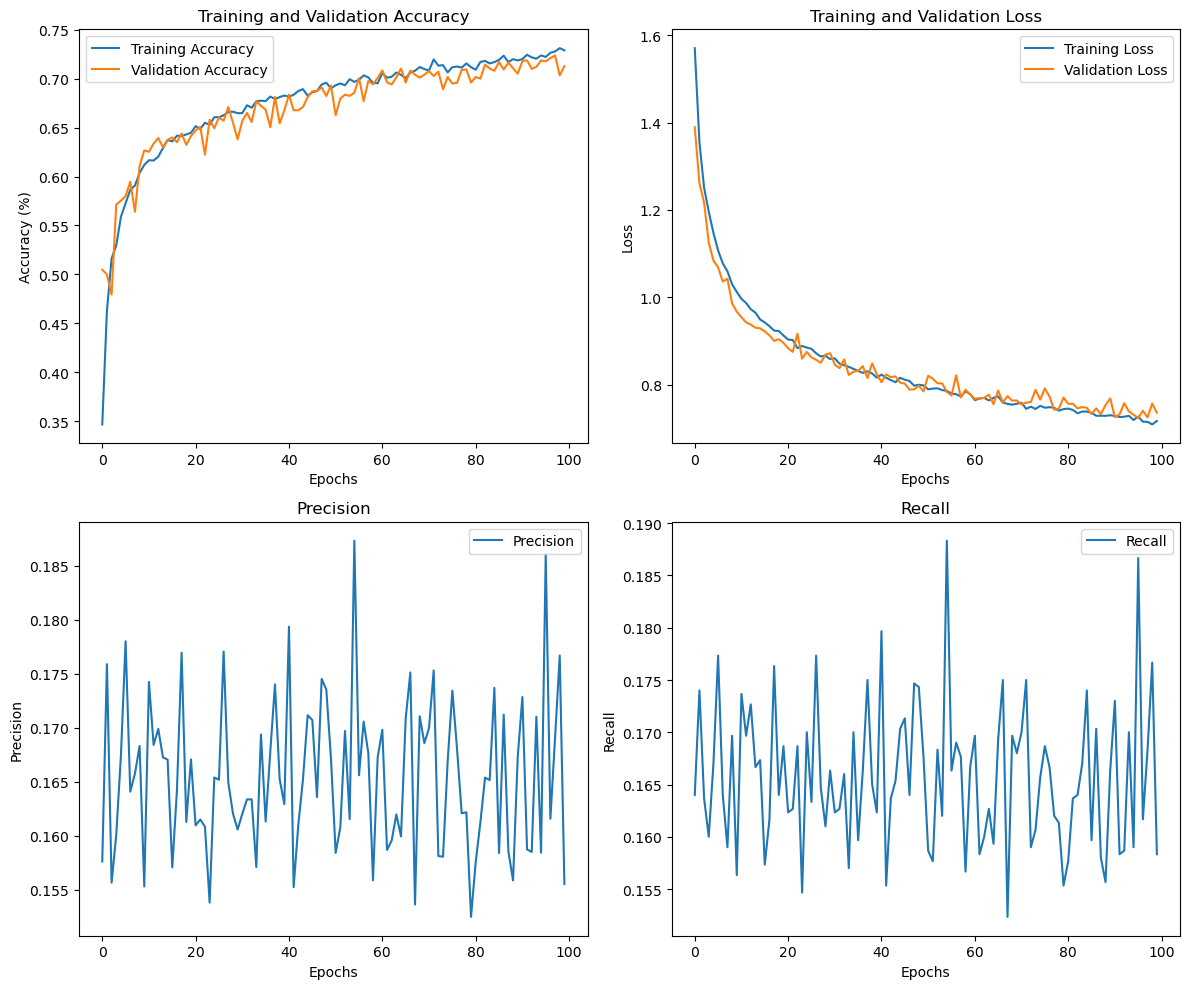

60/60 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7075 - loss: 0.7457
Test Loss: 0.7361, Test Accuracy: 0.71%


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np

# Define paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive 2"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model using pre-trained ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Final layer for classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpoint_resnet50.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics (Precision, Recall, F1-Score, ROC AUC)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on the validation set
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        # Binarize the labels for each class (One-vs-Rest)
        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        # Calculate Precision, Recall, and F1-Score
        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')

        # Calculate ROC AUC (using micro average for multiclass classification)
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        # Log the metrics
        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
        
        # Save metrics for plotting later
        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list = [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)
# Initialize the custom metrics callback
metrics_callback = MetricsCallback()

# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]  # Use the metrics_callback instance
)
model.save('resNet_model.keras')
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 10))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Plot
plt.subplot(2, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Plot
plt.subplot(2, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 625ms/step
Epoch 1: Precision: 0.0306, Recall: 0.1750, F1-Score: 0.0521, ROC AUC: 0.5050
281/281 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.1732 - loss: 1.7931 - val_accuracy: 0.1750 - val_loss: 1.7885
Epoch 2/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 637ms/step
Epoch 2: Precision: 0.0306, Recall: 0.1750, F1-Score: 0.0521, ROC AUC: 0.5050
281/281 ━━━━━━━━━━━━━━━━━━━━ 265s 937ms/step - accuracy: 0.1690 - loss: 1.7922 - val_accuracy: 0.1750 - val_loss: 1.7919
Epoch 3/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 631ms/step
Epoch 3: Precision: 0.0306, Recall: 0.1750, F1-Score: 0.0521, ROC AUC: 0.5050
281/281 ━━━━━━━━━━━━━━━━━━━━ 271s 958ms/step - accuracy: 0.1797 - loss: 1.7923 - val_accuracy: 0.1750 - val_loss: 1.7901
Epoch 4/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 648ms/step
Epoch 4: Precision: 0.0340, Recall: 0.1843, F1-Score: 0.0574, ROC AUC: 0.5106
281/281 ━━━━━━━━━━━━━━━━━━━━ 275s 973ms/step - accuracy: 0.1727 - loss: 1.7916 - val_accuracy: 0.1843 - val_loss: 1.7889
Epoch 5/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 645ms/step
Epoch 5: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0478, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 280s 990ms/step - accuracy: 0.1849 - loss: 1.7899 - val_accuracy: 0.1670 - val_loss: 1.7915
Epoch 6/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 656ms/step
Epoch 6: Precision: 0.2029, Recall: 0.1673, F1-Score: 0.0485, ROC AUC: 0.5004
281/281 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.1771 - loss: 1.7910 - val_accuracy: 0.1670 - val_loss: 1.7905
Epoch 7/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step
Epoch 7: Precision: 0.0528, Recall: 0.1710, F1-Score: 0.0632, ROC AUC: 0.5026
281/281 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.1864 - loss: 1.7895 - val_accuracy: 0.1947 - val_loss: 1.7900
Epoch 8/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 660ms/step
Epoch 8: Precision: 0.0340, Recall: 0.1843, F1-Score: 0.0574, ROC AUC: 0.5106
281/281 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.1814 - loss: 1.7903 - val_accuracy: 0.1843 - val_loss: 1.7869
Epoch 9/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 688ms/step
Epoch 9: Precision: 0.0621, Recall: 0.1727, F1-Score: 0.0871, ROC AUC: 0.5036
281/281 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.1772 - loss: 1.7901 - val_accuracy: 0.2347 - val_loss: 1.7872
Epoch 10/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 647ms/step
Epoch 10: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0478, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.1826 - loss: 1.7898 - val_accuracy: 0.1670 - val_loss: 1.7900
Epoch 11/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 692ms/step
Epoch 11: Precision: 0.0306, Recall: 0.1750, F1-Score: 0.0521, ROC AUC: 0.5050
281/281 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.1752 - loss: 1.7901 - val_accuracy: 0.1750 - val_loss: 1.7880
Epoch 12/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step
Epoch 12: Precision: 0.0306, Recall: 0.1747, F1-Score: 0.0521, ROC AUC: 0.5048
281/281 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.1789 - loss: 1.7896 - val_accuracy: 0.1750 - val_loss: 1.7867
Epoch 13/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 780ms/step
Epoch 13: Precision: 0.0306, Recall: 0.1747, F1-Score: 0.0520, ROC AUC: 0.5048
281/281 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.1785 - loss: 1.7898 - val_accuracy: 0.1750 - val_loss: 1.7867
Epoch 14/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 657ms/step
Epoch 14: Precision: 0.0306, Recall: 0.1750, F1-Score: 0.0521, ROC AUC: 0.5050
281/281 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.1729 - loss: 1.7907 - val_accuracy: 0.1750 - val_loss: 1.7866
Epoch 15/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 659ms/step
Epoch 15: Precision: 0.0537, Recall: 0.1747, F1-Score: 0.0546, ROC AUC: 0.5048
281/281 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.1847 - loss: 1.7887 - val_accuracy: 0.1767 - val_loss: 1.7871
Epoch 16/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 573ms/step
Epoch 16: Precision: 0.0579, Recall: 0.1693, F1-Score: 0.0745, ROC AUC: 0.5016
281/281 ━━━━━━━━━━━━━━━━━━━━ 272s 963ms/step - accuracy: 0.1839 - loss: 1.7888 - val_accuracy: 0.2037 - val_loss: 1.7876
Epoch 17/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 579ms/step
Epoch 17: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0478, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 249s 880ms/step - accuracy: 0.1861 - loss: 1.7885 - val_accuracy: 0.1670 - val_loss: 1.7880
Epoch 18/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 642ms/step
Epoch 18: Precision: 0.0583, Recall: 0.1650, F1-Score: 0.0771, ROC AUC: 0.4990
281/281 ━━━━━━━━━━━━━━━━━━━━ 260s 920ms/step - accuracy: 0.1838 - loss: 1.7880 - val_accuracy: 0.2130 - val_loss: 1.7865
Epoch 19/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 631ms/step
Epoch 19: Precision: 0.0306, Recall: 0.1747, F1-Score: 0.0521, ROC AUC: 0.5048
281/281 ━━━━━━━━━━━━━━━━━━━━ 270s 954ms/step - accuracy: 0.1846 - loss: 1.7879 - val_accuracy: 0.1750 - val_loss: 1.7854
Epoch 20/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 627ms/step
Epoch 20: Precision: 0.0605, Recall: 0.1703, F1-Score: 0.0766, ROC AUC: 0.5022
281/281 ━━━━━━━━━━━━━━━━━━━━ 276s 977ms/step - accuracy: 0.1795 - loss: 1.7887 - val_accuracy: 0.2040 - val_loss: 1.7862
Epoch 21/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 737ms/step
Epoch 21: Precision: 0.0580, Recall: 0.1727, F1-Score: 0.0849, ROC AUC: 0.5036
281/281 ━━━━━━━━━━━━━━━━━━━━ 279s 988ms/step - accuracy: 0.1807 - loss: 1.7881 - val_accuracy: 0.2517 - val_loss: 1.7867
Epoch 22/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 655ms/step
Epoch 22: Precision: 0.0583, Recall: 0.1747, F1-Score: 0.0690, ROC AUC: 0.5048
281/281 ━━━━━━━━━━━━━━━━━━━━ 279s 985ms/step - accuracy: 0.1835 - loss: 1.7880 - val_accuracy: 0.1903 - val_loss: 1.7859
Epoch 23/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step
Epoch 23: Precision: 0.1420, Recall: 0.1757, F1-Score: 0.0535, ROC AUC: 0.5054
281/281 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.1823 - loss: 1.7889 - val_accuracy: 0.1750 - val_loss: 1.7834
Epoch 24/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 671ms/step
Epoch 24: Precision: 0.0825, Recall: 0.1620, F1-Score: 0.1022, ROC AUC: 0.4972
281/281 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.1878 - loss: 1.7882 - val_accuracy: 0.2920 - val_loss: 1.7849
Epoch 25/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 648ms/step
Epoch 25: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0478, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 272s 963ms/step - accuracy: 0.1812 - loss: 1.7863 - val_accuracy: 0.1670 - val_loss: 1.7881
Epoch 26/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 734ms/step
Epoch 26: Precision: 0.0563, Recall: 0.1643, F1-Score: 0.0803, ROC AUC: 0.4986
281/281 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.1830 - loss: 1.7868 - val_accuracy: 0.2600 - val_loss: 1.7839
Epoch 27/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 716ms/step
Epoch 27: Precision: 0.0594, Recall: 0.1737, F1-Score: 0.0803, ROC AUC: 0.5042
281/281 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.1836 - loss: 1.7867 - val_accuracy: 0.2143 - val_loss: 1.7834
Epoch 28/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 781ms/step
Epoch 28: Precision: 0.0586, Recall: 0.1717, F1-Score: 0.0870, ROC AUC: 0.5030
281/281 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.1893 - loss: 1.7851 - val_accuracy: 0.2753 - val_loss: 1.7828
Epoch 29/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 742ms/step
Epoch 29: Precision: 0.0521, Recall: 0.1743, F1-Score: 0.0545, ROC AUC: 0.5046
281/281 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.1926 - loss: 1.7864 - val_accuracy: 0.1767 - val_loss: 1.7808
Epoch 30/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 752ms/step
Epoch 30: Precision: 0.0579, Recall: 0.1753, F1-Score: 0.0799, ROC AUC: 0.5052
281/281 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.1893 - loss: 1.7855 - val_accuracy: 0.2167 - val_loss: 1.7818
Epoch 31/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 755ms/step
Epoch 31: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0478, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.1821 - loss: 1.7864 - val_accuracy: 0.1670 - val_loss: 1.7891
Epoch 32/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 770ms/step
Epoch 32: Precision: 0.0599, Recall: 0.1747, F1-Score: 0.0870, ROC AUC: 0.5048
281/281 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.2006 - loss: 1.7846 - val_accuracy: 0.2493 - val_loss: 1.7801
Epoch 33/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 772ms/step
Epoch 33: Precision: 0.0614, Recall: 0.1783, F1-Score: 0.0890, ROC AUC: 0.5070
281/281 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.1979 - loss: 1.7852 - val_accuracy: 0.2677 - val_loss: 1.7798
Epoch 34/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 773ms/step
Epoch 34: Precision: 0.0574, Recall: 0.1733, F1-Score: 0.0827, ROC AUC: 0.5040
281/281 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.1947 - loss: 1.7846 - val_accuracy: 0.2380 - val_loss: 1.7792
Epoch 35/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 765ms/step
Epoch 35: Precision: 0.0629, Recall: 0.1777, F1-Score: 0.0831, ROC AUC: 0.5066
281/281 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.1955 - loss: 1.7829 - val_accuracy: 0.2127 - val_loss: 1.7768
Epoch 36/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 772ms/step
Epoch 36: Precision: 0.0762, Recall: 0.1757, F1-Score: 0.0559, ROC AUC: 0.5054
281/281 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.1906 - loss: 1.7835 - val_accuracy: 0.1763 - val_loss: 1.7759
Epoch 37/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 813ms/step
Epoch 37: Precision: 0.0581, Recall: 0.1690, F1-Score: 0.0848, ROC AUC: 0.5014
281/281 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.1936 - loss: 1.7808 - val_accuracy: 0.2713 - val_loss: 1.7781
Epoch 38/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 794ms/step
Epoch 38: Precision: 0.0550, Recall: 0.1673, F1-Score: 0.0817, ROC AUC: 0.5004
281/281 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.2041 - loss: 1.7827 - val_accuracy: 0.2670 - val_loss: 1.7783
Epoch 39/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 789ms/step
Epoch 39: Precision: 0.0638, Recall: 0.1807, F1-Score: 0.0843, ROC AUC: 0.5084
281/281 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.1957 - loss: 1.7823 - val_accuracy: 0.2127 - val_loss: 1.7724
Epoch 40/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 785ms/step
Epoch 40: Precision: 0.0594, Recall: 0.1713, F1-Score: 0.0861, ROC AUC: 0.5028
281/281 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.1949 - loss: 1.7821 - val_accuracy: 0.2697 - val_loss: 1.7755
Epoch 41/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 821ms/step
Epoch 41: Precision: 0.0556, Recall: 0.1667, F1-Score: 0.0714, ROC AUC: 0.5000
281/281 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.1993 - loss: 1.7802 - val_accuracy: 0.2260 - val_loss: 1.7796
Epoch 42/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 776ms/step
Epoch 42: Precision: 0.0279, Recall: 0.1667, F1-Score: 0.0477, ROC AUC: 0.5000
281/281 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.1992 - loss: 1.7805 - val_accuracy: 0.1677 - val_loss: 1.7837
Epoch 43/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 777ms/step
Epoch 43: Precision: 0.0586, Recall: 0.1717, F1-Score: 0.0847, ROC AUC: 0.5030
281/281 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.1976 - loss: 1.7789 - val_accuracy: 0.2433 - val_loss: 1.7689
Epoch 44/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 774ms/step
Epoch 44: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0478, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.1898 - loss: 1.7787 - val_accuracy: 0.1670 - val_loss: 1.7828
Epoch 45/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 761ms/step
Epoch 45: Precision: 0.0612, Recall: 0.1750, F1-Score: 0.0850, ROC AUC: 0.5050
281/281 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.2010 - loss: 1.7770 - val_accuracy: 0.2517 - val_loss: 1.7769
Epoch 46/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 756ms/step
Epoch 46: Precision: 0.0583, Recall: 0.1727, F1-Score: 0.0835, ROC AUC: 0.5036
281/281 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.1951 - loss: 1.7768 - val_accuracy: 0.2393 - val_loss: 1.7716
Epoch 47/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 735ms/step
Epoch 47: Precision: 0.0279, Recall: 0.1670, F1-Score: 0.0479, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.2102 - loss: 1.7758 - val_accuracy: 0.1677 - val_loss: 1.7819
Epoch 48/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 736ms/step
Epoch 48: Precision: 0.2029, Recall: 0.1677, F1-Score: 0.0492, ROC AUC: 0.5006
281/281 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.2133 - loss: 1.7743 - val_accuracy: 0.1677 - val_loss: 1.7773
Epoch 49/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 725ms/step
Epoch 49: Precision: 0.0546, Recall: 0.1647, F1-Score: 0.0689, ROC AUC: 0.4988
281/281 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.2168 - loss: 1.7750 - val_accuracy: 0.2213 - val_loss: 1.7784
Epoch 50/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 727ms/step
Epoch 50: Precision: 0.0548, Recall: 0.1640, F1-Score: 0.0731, ROC AUC: 0.4984
281/281 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.2089 - loss: 1.7726 - val_accuracy: 0.2363 - val_loss: 1.7746
Epoch 51/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 730ms/step
Epoch 51: Precision: 0.0279, Recall: 0.1667, F1-Score: 0.0477, ROC AUC: 0.5000
281/281 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.2144 - loss: 1.7724 - val_accuracy: 0.1677 - val_loss: 1.7842
Epoch 52/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 724ms/step
Epoch 52: Precision: 0.0279, Recall: 0.1667, F1-Score: 0.0477, ROC AUC: 0.5000
281/281 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.2071 - loss: 1.7709 - val_accuracy: 0.1677 - val_loss: 1.7813
Epoch 53/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 723ms/step
Epoch 53: Precision: 0.0542, Recall: 0.1597, F1-Score: 0.0761, ROC AUC: 0.4958
281/281 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.2193 - loss: 1.7689 - val_accuracy: 0.2527 - val_loss: 1.7690
Epoch 54/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 749ms/step
Epoch 54: Precision: 0.0279, Recall: 0.1667, F1-Score: 0.0477, ROC AUC: 0.5000
281/281 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.2012 - loss: 1.7694 - val_accuracy: 0.1677 - val_loss: 1.7860
Epoch 55/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 873ms/step
Epoch 55: Precision: 0.0596, Recall: 0.1730, F1-Score: 0.0884, ROC AUC: 0.5038
281/281 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.2154 - loss: 1.7680 - val_accuracy: 0.2750 - val_loss: 1.7595
Epoch 56/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 757ms/step
Epoch 56: Precision: 0.0508, Recall: 0.1587, F1-Score: 0.0458, ROC AUC: 0.4952
281/281 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.2156 - loss: 1.7654 - val_accuracy: 0.1580 - val_loss: 1.8007
Epoch 57/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 798ms/step
Epoch 57: Precision: 0.0278, Recall: 0.1663, F1-Score: 0.0476, ROC AUC: 0.4998
281/281 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.2126 - loss: 1.7674 - val_accuracy: 0.1677 - val_loss: 1.7869
Epoch 58/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 750ms/step
Epoch 58: Precision: 0.0483, Recall: 0.1623, F1-Score: 0.0656, ROC AUC: 0.4974
281/281 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.2155 - loss: 1.7658 - val_accuracy: 0.1840 - val_loss: 1.7864
Epoch 59/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 937ms/step
Epoch 59: Precision: 0.0984, Recall: 0.1683, F1-Score: 0.0548, ROC AUC: 0.5010
281/281 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.2209 - loss: 1.7627 - val_accuracy: 0.1713 - val_loss: 1.7759
Epoch 60/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 748ms/step
Epoch 60: Precision: 0.0547, Recall: 0.1673, F1-Score: 0.0790, ROC AUC: 0.5004
281/281 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.2114 - loss: 1.7631 - val_accuracy: 0.1790 - val_loss: 1.7930
Epoch 61/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 773ms/step
Epoch 61: Precision: 0.0501, Recall: 0.1667, F1-Score: 0.0591, ROC AUC: 0.5000
281/281 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.2233 - loss: 1.7616 - val_accuracy: 0.1753 - val_loss: 1.7925
Epoch 62/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 723ms/step
Epoch 62: Precision: 0.0513, Recall: 0.1577, F1-Score: 0.0773, ROC AUC: 0.4946
281/281 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.2291 - loss: 1.7599 - val_accuracy: 0.1703 - val_loss: 1.7851
Epoch 63/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 722ms/step
Epoch 63: Precision: 0.2278, Recall: 0.1670, F1-Score: 0.0520, ROC AUC: 0.5002
281/281 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.2218 - loss: 1.7590 - val_accuracy: 0.1690 - val_loss: 1.7834
Epoch 64/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 776ms/step
Epoch 64: Precision: 0.0520, Recall: 0.1663, F1-Score: 0.0674, ROC AUC: 0.4998
281/281 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.2249 - loss: 1.7592 - val_accuracy: 0.1813 - val_loss: 1.7882
Epoch 65/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 704ms/step
Epoch 65: Precision: 0.0551, Recall: 0.1697, F1-Score: 0.0832, ROC AUC: 0.5018
281/281 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.2237 - loss: 1.7575 - val_accuracy: 0.1730 - val_loss: 1.7955
Epoch 66/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step
Epoch 66: Precision: 0.0486, Recall: 0.1513, F1-Score: 0.0692, ROC AUC: 0.4908
281/281 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.2300 - loss: 1.7544 - val_accuracy: 0.1593 - val_loss: 1.8020
Epoch 67/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 776ms/step
Epoch 67: Precision: 0.0498, Recall: 0.1567, F1-Score: 0.0627, ROC AUC: 0.4940
281/281 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.2212 - loss: 1.7550 - val_accuracy: 0.1573 - val_loss: 1.8107
Epoch 68/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 761ms/step
Epoch 68: Precision: 0.0528, Recall: 0.1657, F1-Score: 0.0600, ROC AUC: 0.4994
281/281 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.2212 - loss: 1.7538 - val_accuracy: 0.1757 - val_loss: 1.7958
Epoch 69/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 780ms/step
Epoch 69: Precision: 0.0537, Recall: 0.1700, F1-Score: 0.0691, ROC AUC: 0.5020
281/281 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.2378 - loss: 1.7491 - val_accuracy: 0.1820 - val_loss: 1.7872
Epoch 70/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 725ms/step
Epoch 70: Precision: 0.0484, Recall: 0.1557, F1-Score: 0.0709, ROC AUC: 0.4934
281/281 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.2232 - loss: 1.7510 - val_accuracy: 0.1797 - val_loss: 1.7906
Epoch 71/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 677ms/step
Epoch 71: Precision: 0.1383, Recall: 0.1550, F1-Score: 0.0758, ROC AUC: 0.4930
281/281 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.2355 - loss: 1.7497 - val_accuracy: 0.1633 - val_loss: 1.7811
Epoch 72/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 675ms/step
Epoch 72: Precision: 0.1721, Recall: 0.1700, F1-Score: 0.0732, ROC AUC: 0.5020
281/281 ━━━━━━━━━━━━━━━━━━━━ 279s 987ms/step - accuracy: 0.2397 - loss: 1.7433 - val_accuracy: 0.1833 - val_loss: 1.7795
Epoch 73/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 734ms/step
Epoch 73: Precision: 0.1407, Recall: 0.1637, F1-Score: 0.0808, ROC AUC: 0.4982
281/281 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.2248 - loss: 1.7468 - val_accuracy: 0.1707 - val_loss: 1.7811
Epoch 74/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 720ms/step
Epoch 74: Precision: 0.0411, Recall: 0.1557, F1-Score: 0.0468, ROC AUC: 0.4934
281/281 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.2342 - loss: 1.7425 - val_accuracy: 0.1580 - val_loss: 1.8004
Epoch 75/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 638ms/step
Epoch 75: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.2397 - loss: 1.7423 - val_accuracy: 0.1580 - val_loss: 1.8192
Epoch 76/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 687ms/step
Epoch 76: Precision: 0.0595, Recall: 0.1597, F1-Score: 0.0558, ROC AUC: 0.4958
281/281 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.2343 - loss: 1.7409 - val_accuracy: 0.1580 - val_loss: 1.8088
Epoch 77/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 747ms/step
Epoch 77: Precision: 0.0469, Recall: 0.1567, F1-Score: 0.0509, ROC AUC: 0.4940
281/281 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.2409 - loss: 1.7380 - val_accuracy: 0.1580 - val_loss: 1.8114
Epoch 78/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 774ms/step
Epoch 78: Precision: 0.1128, Recall: 0.1637, F1-Score: 0.0789, ROC AUC: 0.4982
281/281 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.2378 - loss: 1.7410 - val_accuracy: 0.1610 - val_loss: 1.7787
Epoch 79/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 741ms/step
Epoch 79: Precision: 0.0557, Recall: 0.1593, F1-Score: 0.0508, ROC AUC: 0.4956
281/281 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.2293 - loss: 1.7366 - val_accuracy: 0.1580 - val_loss: 1.8018
Epoch 80/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 743ms/step
Epoch 80: Precision: 0.0652, Recall: 0.1617, F1-Score: 0.0534, ROC AUC: 0.4970
281/281 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.2383 - loss: 1.7341 - val_accuracy: 0.1580 - val_loss: 1.8042
Epoch 81/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 623ms/step
Epoch 81: Precision: 0.0527, Recall: 0.1577, F1-Score: 0.0461, ROC AUC: 0.4946
281/281 ━━━━━━━━━━━━━━━━━━━━ 270s 954ms/step - accuracy: 0.2443 - loss: 1.7342 - val_accuracy: 0.1580 - val_loss: 1.8091
Epoch 82/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 706ms/step
Epoch 82: Precision: 0.0548, Recall: 0.1633, F1-Score: 0.0779, ROC AUC: 0.4980
281/281 ━━━━━━━━━━━━━━━━━━━━ 275s 972ms/step - accuracy: 0.2313 - loss: 1.7373 - val_accuracy: 0.1597 - val_loss: 1.8015
Epoch 83/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 871ms/step
Epoch 83: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.2422 - loss: 1.7309 - val_accuracy: 0.1580 - val_loss: 1.8422
Epoch 84/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 975ms/step
Epoch 84: Precision: 0.0518, Recall: 0.1567, F1-Score: 0.0767, ROC AUC: 0.4940
281/281 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.2352 - loss: 1.7307 - val_accuracy: 0.1630 - val_loss: 1.7993
Epoch 85/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 890ms/step
Epoch 85: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.2428 - loss: 1.7210 - val_accuracy: 0.1580 - val_loss: 1.8312
Epoch 86/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step
Epoch 86: Precision: 0.0503, Recall: 0.1557, F1-Score: 0.0674, ROC AUC: 0.4934
281/281 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.2448 - loss: 1.7236 - val_accuracy: 0.1580 - val_loss: 1.8065
Epoch 87/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 977ms/step
Epoch 87: Precision: 0.0537, Recall: 0.1603, F1-Score: 0.0525, ROC AUC: 0.4962
281/281 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.2388 - loss: 1.7275 - val_accuracy: 0.1580 - val_loss: 1.8229
Epoch 88/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 822ms/step
Epoch 88: Precision: 0.0566, Recall: 0.1583, F1-Score: 0.0515, ROC AUC: 0.4950
281/281 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.2455 - loss: 1.7217 - val_accuracy: 0.1580 - val_loss: 1.8131
Epoch 89/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 770ms/step
Epoch 89: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.2449 - loss: 1.7207 - val_accuracy: 0.1580 - val_loss: 1.8648
Epoch 90/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 823ms/step
Epoch 90: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.2447 - loss: 1.7239 - val_accuracy: 0.1580 - val_loss: 1.8365
Epoch 91/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step
Epoch 91: Precision: 0.0251, Recall: 0.1580, F1-Score: 0.0433, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.2477 - loss: 1.7194 - val_accuracy: 0.1580 - val_loss: 1.8417
Epoch 92/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step
Epoch 92: Precision: 0.0471, Recall: 0.1520, F1-Score: 0.0648, ROC AUC: 0.4912
281/281 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.2413 - loss: 1.7180 - val_accuracy: 0.1583 - val_loss: 1.8036
Epoch 93/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step
Epoch 93: Precision: 0.0807, Recall: 0.1587, F1-Score: 0.0445, ROC AUC: 0.4952
281/281 ━━━━━━━━━━━━━━━━━━━━ 783s 3s/step - accuracy: 0.2420 - loss: 1.7156 - val_accuracy: 0.1580 - val_loss: 1.8518
Epoch 94/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Epoch 94: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - accuracy: 0.2429 - loss: 1.7192 - val_accuracy: 0.1580 - val_loss: 1.8422
Epoch 95/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step
Epoch 95: Precision: 0.0769, Recall: 0.1600, F1-Score: 0.0489, ROC AUC: 0.4960
281/281 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.2397 - loss: 1.7148 - val_accuracy: 0.1580 - val_loss: 1.8470
Epoch 96/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
Epoch 96: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.2499 - loss: 1.7122 - val_accuracy: 0.1580 - val_loss: 1.8509
Epoch 97/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step
Epoch 97: Precision: 0.0505, Recall: 0.1570, F1-Score: 0.0453, ROC AUC: 0.4942
281/281 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.2466 - loss: 1.7137 - val_accuracy: 0.1580 - val_loss: 1.8377
Epoch 98/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step
Epoch 98: Precision: 0.0369, Recall: 0.1577, F1-Score: 0.0438, ROC AUC: 0.4946
281/281 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.2487 - loss: 1.7089 - val_accuracy: 0.1580 - val_loss: 1.8556
Epoch 99/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Epoch 99: Precision: 0.0250, Recall: 0.1580, F1-Score: 0.0431, ROC AUC: 0.4948
281/281 ━━━━━━━━━━━━━━━━━━━━ 725s 3s/step - accuracy: 0.2527 - loss: 1.7083 - val_accuracy: 0.1580 - val_loss: 1.8472
Epoch 100/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 100: Precision: 0.0528, Recall: 0.1583, F1-Score: 0.0451, ROC AUC: 0.4950
281/281 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.2524 - loss: 1.7005 - val_accuracy: 0.1580 - val_loss: 1.8612


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


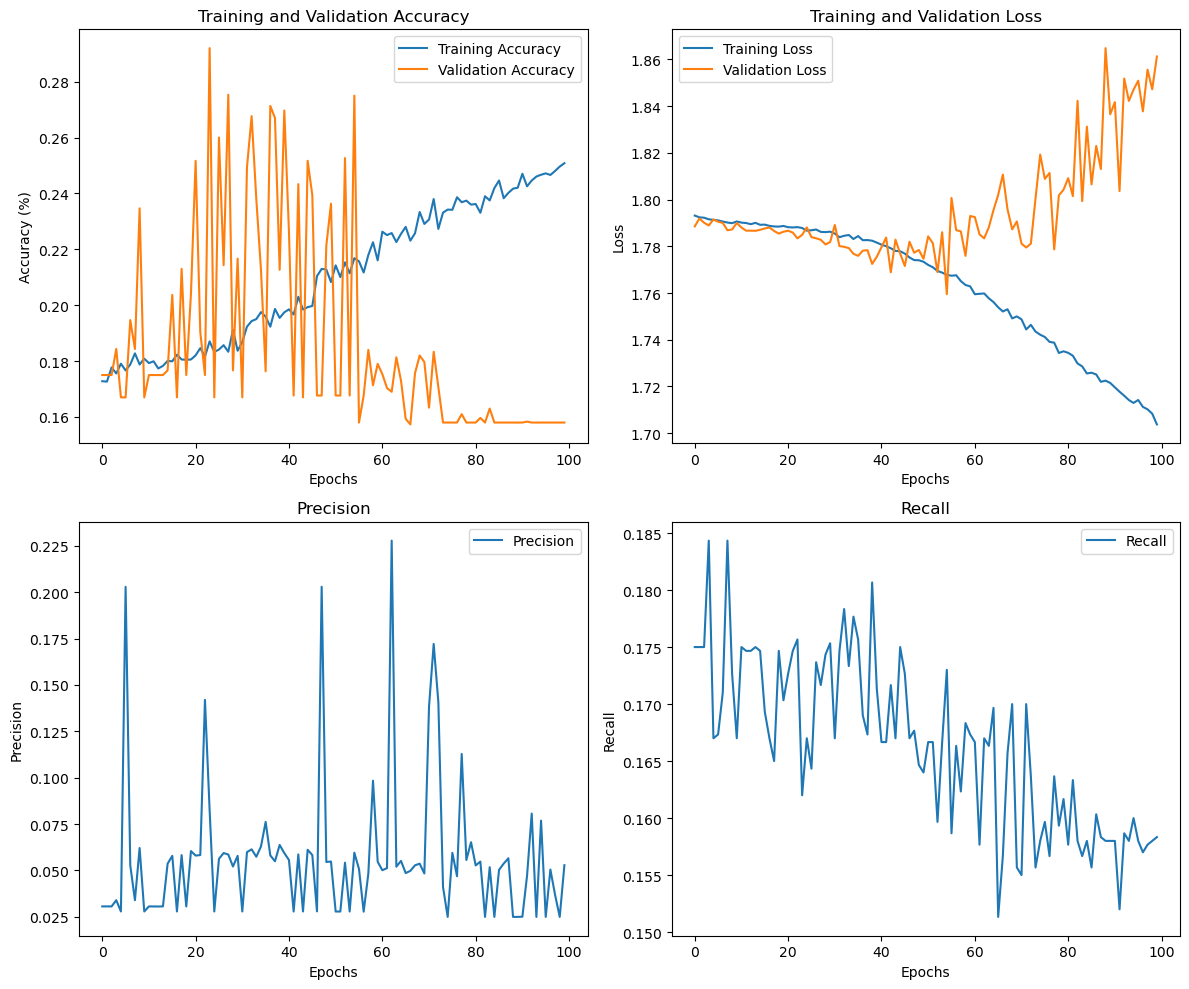

60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1646 - loss: 1.8567
Test Loss: 1.8612, Test Accuracy: 0.16%


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

# Define paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive 2"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model using pre-trained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpoint_efficientnetb0.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics (Precision, Recall, F1-Score, ROC AUC)
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on the validation set
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        # Binarize the labels for each class (One-vs-Rest)
        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        # Calculate Precision, Recall, and F1-Score
        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')

        # Calculate ROC AUC (using micro average for multiclass classification)
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        # Log the metrics
        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
        
        # Save metrics for plotting later
        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list = [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)

# Initialize the custom metrics callback
metrics_callback = MetricsCallback()

# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]
)

# Save the final model
model.save('best_model_efficientnetb0.h5')

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 10))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Plot
plt.subplot(2, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Plot
plt.subplot(2, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
Epoch 1: Precision: 0.0452, Recall: 0.1730, F1-Score: 0.0542, ROC AUC: 0.5038, Sensitivity: 0.1649, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.1786 - loss: 1.8000 - val_accuracy: 0.1807 - val_loss: 1.7728
Epoch 2/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step
Epoch 2: Precision: 0.0869, Recall: 0.1533, F1-Score: 0.0730, ROC AUC: 0.4920, Sensitivity: 0.1705, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.1999 - loss: 1.7808 - val_accuracy: 0.1687 - val_loss: 1.7532
Epoch 3/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Epoch 3: Precision: 0.0577, Recall: 0.1823, F1-Score: 0.0739, ROC AUC: 0.5094, Sensitivity: 0.1669, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.2131 - loss: 1.7720 - val_accuracy: 0.2203 - val_loss: 1.7317
Epoch 4/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 4: Precision: 0.0581, Recall: 0.1763, F1-Score: 0.0851, ROC AUC: 0.5058, Sensitivity: 0.1731, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.2191 - loss: 1.7659 - val_accuracy: 0.2607 - val_loss: 1.7295
Epoch 5/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 5: Precision: 0.0967, Recall: 0.1823, F1-Score: 0.1048, ROC AUC: 0.5094, Sensitivity: 0.1770, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.2322 - loss: 1.7590 - val_accuracy: 0.2450 - val_loss: 1.7145
Epoch 6/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 6: Precision: 0.1384, Recall: 0.1617, F1-Score: 0.1389, ROC AUC: 0.4970, Sensitivity: 0.1590, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.2303 - loss: 1.7505 - val_accuracy: 0.2857 - val_loss: 1.7058
Epoch 7/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Epoch 7: Precision: 0.0898, Recall: 0.1807, F1-Score: 0.1040, ROC AUC: 0.5084, Sensitivity: 0.1771, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.2395 - loss: 1.7533 - val_accuracy: 0.2567 - val_loss: 1.7117
Epoch 8/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 8: Precision: 0.0858, Recall: 0.1677, F1-Score: 0.1127, ROC AUC: 0.5006, Sensitivity: 0.1608, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.2339 - loss: 1.7490 - val_accuracy: 0.2907 - val_loss: 1.6890
Epoch 9/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 9: Precision: 0.0854, Recall: 0.1750, F1-Score: 0.1025, ROC AUC: 0.5050, Sensitivity: 0.1702, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.2389 - loss: 1.7413 - val_accuracy: 0.2653 - val_loss: 1.6910
Epoch 10/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 10: Precision: 0.0558, Recall: 0.1683, F1-Score: 0.0837, ROC AUC: 0.5010, Sensitivity: 0.1673, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.2470 - loss: 1.7374 - val_accuracy: 0.2677 - val_loss: 1.6811
Epoch 11/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 11: Precision: 0.1208, Recall: 0.1753, F1-Score: 0.1264, ROC AUC: 0.5052, Sensitivity: 0.1697, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.2463 - loss: 1.7314 - val_accuracy: 0.3083 - val_loss: 1.6772
Epoch 12/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step
Epoch 12: Precision: 0.0871, Recall: 0.1743, F1-Score: 0.1132, ROC AUC: 0.5046, Sensitivity: 0.1675, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.2513 - loss: 1.7319 - val_accuracy: 0.3070 - val_loss: 1.6860
Epoch 13/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step
Epoch 13: Precision: 0.1150, Recall: 0.1693, F1-Score: 0.1249, ROC AUC: 0.5016, Sensitivity: 0.1660, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.2536 - loss: 1.7313 - val_accuracy: 0.2800 - val_loss: 1.6773
Epoch 14/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step
Epoch 14: Precision: 0.1261, Recall: 0.1790, F1-Score: 0.1267, ROC AUC: 0.5074, Sensitivity: 0.1747, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.2549 - loss: 1.7192 - val_accuracy: 0.2767 - val_loss: 1.6763
Epoch 15/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step
Epoch 15: Precision: 0.0871, Recall: 0.1763, F1-Score: 0.1079, ROC AUC: 0.5058, Sensitivity: 0.1727, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.2528 - loss: 1.7221 - val_accuracy: 0.2713 - val_loss: 1.6714
Epoch 16/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step
Epoch 16: Precision: 0.1713, Recall: 0.1657, F1-Score: 0.0993, ROC AUC: 0.4994, Sensitivity: 0.1676, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.2552 - loss: 1.7144 - val_accuracy: 0.2710 - val_loss: 1.6823
Epoch 17/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step
Epoch 17: Precision: 0.1124, Recall: 0.1687, F1-Score: 0.1041, ROC AUC: 0.5012, Sensitivity: 0.1671, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.2559 - loss: 1.7153 - val_accuracy: 0.2787 - val_loss: 1.6656
Epoch 18/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step
Epoch 18: Precision: 0.1074, Recall: 0.1637, F1-Score: 0.1131, ROC AUC: 0.4982, Sensitivity: 0.1591, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.2541 - loss: 1.7135 - val_accuracy: 0.2787 - val_loss: 1.6705
Epoch 19/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step
Epoch 19: Precision: 0.1405, Recall: 0.1660, F1-Score: 0.1227, ROC AUC: 0.4996, Sensitivity: 0.1645, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.2506 - loss: 1.7153 - val_accuracy: 0.2677 - val_loss: 1.6825
Epoch 20/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step
Epoch 20: Precision: 0.1252, Recall: 0.1817, F1-Score: 0.1286, ROC AUC: 0.5090, Sensitivity: 0.1759, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.2640 - loss: 1.7013 - val_accuracy: 0.2890 - val_loss: 1.6669
Epoch 21/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
Epoch 21: Precision: 0.1116, Recall: 0.1760, F1-Score: 0.1121, ROC AUC: 0.5056, Sensitivity: 0.1727, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 708s 3s/step - accuracy: 0.2571 - loss: 1.7119 - val_accuracy: 0.2817 - val_loss: 1.6774
Epoch 22/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step
Epoch 22: Precision: 0.1427, Recall: 0.1700, F1-Score: 0.1446, ROC AUC: 0.5020, Sensitivity: 0.1683, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.2627 - loss: 1.6999 - val_accuracy: 0.2953 - val_loss: 1.6614
Epoch 23/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Epoch 23: Precision: 0.1540, Recall: 0.1767, F1-Score: 0.1303, ROC AUC: 0.5060, Sensitivity: 0.1736, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 737s 3s/step - accuracy: 0.2689 - loss: 1.7031 - val_accuracy: 0.2620 - val_loss: 1.6996
Epoch 24/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step
Epoch 24: Precision: 0.0827, Recall: 0.1677, F1-Score: 0.1030, ROC AUC: 0.5006, Sensitivity: 0.1653, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 711s 3s/step - accuracy: 0.2561 - loss: 1.7021 - val_accuracy: 0.2773 - val_loss: 1.6497
Epoch 25/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Epoch 25: Precision: 0.1525, Recall: 0.1703, F1-Score: 0.1392, ROC AUC: 0.5022, Sensitivity: 0.1683, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 737s 3s/step - accuracy: 0.2627 - loss: 1.7048 - val_accuracy: 0.2940 - val_loss: 1.6589
Epoch 26/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step
Epoch 26: Precision: 0.1320, Recall: 0.1540, F1-Score: 0.1243, ROC AUC: 0.4924, Sensitivity: 0.1508, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.2579 - loss: 1.7051 - val_accuracy: 0.2810 - val_loss: 1.6683
Epoch 27/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 27: Precision: 0.1815, Recall: 0.1707, F1-Score: 0.1423, ROC AUC: 0.5024, Sensitivity: 0.1693, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.2695 - loss: 1.6942 - val_accuracy: 0.2770 - val_loss: 1.6781
Epoch 28/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step
Epoch 28: Precision: 0.1111, Recall: 0.1700, F1-Score: 0.1132, ROC AUC: 0.5020, Sensitivity: 0.1678, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.2700 - loss: 1.6935 - val_accuracy: 0.2737 - val_loss: 1.6733
Epoch 29/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 29: Precision: 0.1475, Recall: 0.1683, F1-Score: 0.1355, ROC AUC: 0.5010, Sensitivity: 0.1665, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.2629 - loss: 1.6948 - val_accuracy: 0.2890 - val_loss: 1.6556
Epoch 30/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 30: Precision: 0.1162, Recall: 0.1730, F1-Score: 0.1257, ROC AUC: 0.5038, Sensitivity: 0.1676, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.2667 - loss: 1.6939 - val_accuracy: 0.2903 - val_loss: 1.6635
Epoch 31/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 31: Precision: 0.1434, Recall: 0.1667, F1-Score: 0.1338, ROC AUC: 0.5000, Sensitivity: 0.1642, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.2682 - loss: 1.6915 - val_accuracy: 0.2867 - val_loss: 1.6649
Epoch 32/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Epoch 32: Precision: 0.1416, Recall: 0.1743, F1-Score: 0.1467, ROC AUC: 0.5046, Sensitivity: 0.1723, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.2776 - loss: 1.6888 - val_accuracy: 0.2987 - val_loss: 1.6470
Epoch 33/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 33: Precision: 0.1023, Recall: 0.1677, F1-Score: 0.1012, ROC AUC: 0.5006, Sensitivity: 0.1635, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.2728 - loss: 1.6861 - val_accuracy: 0.2777 - val_loss: 1.6585
Epoch 34/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 34: Precision: 0.1676, Recall: 0.1697, F1-Score: 0.1391, ROC AUC: 0.5018, Sensitivity: 0.1690, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.2683 - loss: 1.6893 - val_accuracy: 0.3157 - val_loss: 1.6527
Epoch 35/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 35: Precision: 0.1899, Recall: 0.1740, F1-Score: 0.1419, ROC AUC: 0.5044, Sensitivity: 0.1742, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.2652 - loss: 1.6877 - val_accuracy: 0.2803 - val_loss: 1.6653
Epoch 36/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 36: Precision: 0.1276, Recall: 0.1620, F1-Score: 0.1236, ROC AUC: 0.4972, Sensitivity: 0.1645, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.2646 - loss: 1.6855 - val_accuracy: 0.2753 - val_loss: 1.6673
Epoch 37/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 37: Precision: 0.1420, Recall: 0.1690, F1-Score: 0.1388, ROC AUC: 0.5014, Sensitivity: 0.1656, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.2707 - loss: 1.6885 - val_accuracy: 0.2857 - val_loss: 1.6555
Epoch 38/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Epoch 38: Precision: 0.1479, Recall: 0.1810, F1-Score: 0.1510, ROC AUC: 0.5086, Sensitivity: 0.1807, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.2621 - loss: 1.6819 - val_accuracy: 0.3003 - val_loss: 1.6481
Epoch 39/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 39: Precision: 0.1635, Recall: 0.1723, F1-Score: 0.1312, ROC AUC: 0.5034, Sensitivity: 0.1698, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.2653 - loss: 1.6910 - val_accuracy: 0.2747 - val_loss: 1.6699
Epoch 40/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 40: Precision: 0.1434, Recall: 0.1750, F1-Score: 0.1366, ROC AUC: 0.5050, Sensitivity: 0.1737, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.2608 - loss: 1.6866 - val_accuracy: 0.2940 - val_loss: 1.6439
Epoch 41/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 41: Precision: 0.1208, Recall: 0.1807, F1-Score: 0.1385, ROC AUC: 0.5084, Sensitivity: 0.1784, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.2645 - loss: 1.6894 - val_accuracy: 0.2877 - val_loss: 1.6566
Epoch 42/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 42: Precision: 0.1301, Recall: 0.1587, F1-Score: 0.1296, ROC AUC: 0.4952, Sensitivity: 0.1578, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.2689 - loss: 1.6827 - val_accuracy: 0.2963 - val_loss: 1.6425
Epoch 43/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 43: Precision: 0.1150, Recall: 0.1747, F1-Score: 0.1310, ROC AUC: 0.5048, Sensitivity: 0.1718, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.2773 - loss: 1.6729 - val_accuracy: 0.2750 - val_loss: 1.6780
Epoch 44/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 44: Precision: 0.1501, Recall: 0.1737, F1-Score: 0.1487, ROC AUC: 0.5042, Sensitivity: 0.1714, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.2642 - loss: 1.6762 - val_accuracy: 0.3070 - val_loss: 1.6337
Epoch 45/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 45: Precision: 0.1847, Recall: 0.1660, F1-Score: 0.1172, ROC AUC: 0.4996, Sensitivity: 0.1640, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.2709 - loss: 1.6810 - val_accuracy: 0.2673 - val_loss: 1.6815
Epoch 46/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 46: Precision: 0.1661, Recall: 0.1697, F1-Score: 0.1293, ROC AUC: 0.5018, Sensitivity: 0.1680, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.2785 - loss: 1.6804 - val_accuracy: 0.2897 - val_loss: 1.6542
Epoch 47/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 47: Precision: 0.1196, Recall: 0.1677, F1-Score: 0.1241, ROC AUC: 0.5006, Sensitivity: 0.1671, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.2693 - loss: 1.6820 - val_accuracy: 0.2943 - val_loss: 1.6468
Epoch 48/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
Epoch 48: Precision: 0.1749, Recall: 0.1767, F1-Score: 0.1438, ROC AUC: 0.5060, Sensitivity: 0.1756, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.2675 - loss: 1.6869 - val_accuracy: 0.2953 - val_loss: 1.6436
Epoch 49/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step
Epoch 49: Precision: 0.1548, Recall: 0.1770, F1-Score: 0.1495, ROC AUC: 0.5062, Sensitivity: 0.1747, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.2733 - loss: 1.6785 - val_accuracy: 0.2960 - val_loss: 1.6372
Epoch 50/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 50: Precision: 0.1684, Recall: 0.1673, F1-Score: 0.1226, ROC AUC: 0.5004, Sensitivity: 0.1652, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.2722 - loss: 1.6783 - val_accuracy: 0.2873 - val_loss: 1.6563
Epoch 51/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Epoch 51: Precision: 0.1610, Recall: 0.1643, F1-Score: 0.1267, ROC AUC: 0.4986, Sensitiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 53: Precision: 0.1550, Recall: 0.1707, F1-Score: 0.1278, ROC AUC: 0.5024, Sensitivity: 0.1706, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.2801 - loss: 1.6648 - val_accuracy: 0.2840 - val_loss: 1.6496
Epoch 54/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 54: Precision: 0.1396, Recall: 0.1667, F1-Score: 0.1239, ROC AUC: 0.5000, Sensitivity: 0.1645, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.2673 - loss: 1.6796 - val_accuracy: 0.2767 - val_loss: 1.6664
Epoch 55/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 55: Precision: 0.1673, Recall: 0.1650, F1-Score: 0.1320, ROC AUC: 0.4990, Sensitivity: 0.1642, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.2721 - loss: 1.6761 - val_accuracy: 0.2910 - val_loss: 1.6506
Epoch 56/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 56: Precision: 0.1323, Recall: 0.1643, F1-Score: 0.1404, ROC AUC: 0.4986, Sensitiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 57: Precision: 0.1705, Recall: 0.1583, F1-Score: 0.1337, ROC AUC: 0.4950, Sensitivity: 0.1566, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.2746 - loss: 1.6760 - val_accuracy: 0.3013 - val_loss: 1.6390
Epoch 58/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 58: Precision: 0.1549, Recall: 0.1663, F1-Score: 0.1439, ROC AUC: 0.4998, Sensitivity: 0.1642, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.2655 - loss: 1.6790 - val_accuracy: 0.3080 - val_loss: 1.6309
Epoch 59/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 59: Precision: 0.1606, Recall: 0.1623, F1-Score: 0.1280, ROC AUC: 0.4974, Sensitivity: 0.1610, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.2798 - loss: 1.6719 - val_accuracy: 0.2837 - val_loss: 1.6545
Epoch 60/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 60: Precision: 0.1286, Recall: 0.1593, F1-Score: 0.1229, ROC AUC: 0.4956, Sensitivity: 0.1595, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.2793 - loss: 1.6715 - val_accuracy: 0.2937 - val_loss: 1.6455
Epoch 61/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 61: Precision: 0.1467, Recall: 0.1653, F1-Score: 0.1365, ROC AUC: 0.4992, Sensitivity: 0.1629, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.2798 - loss: 1.6658 - val_accuracy: 0.2963 - val_loss: 1.6363
Epoch 62/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 62: Precision: 0.1345, Recall: 0.1633, F1-Score: 0.1228, ROC AUC: 0.4980, Sensitivity: 0.1619, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.2772 - loss: 1.6637 - val_accuracy: 0.2900 - val_loss: 1.6511
Epoch 63/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Epoch 63: Precision: 0.1415, Recall: 0.1713, F1-Score: 0.1315, ROC AUC: 0.5028, Sensitivity: 0.1757, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.2809 - loss: 1.6652 - val_accuracy: 0.2927 - val_loss: 1.6348
Epoch 64/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step
Epoch 64: Precision: 0.1825, Recall: 0.1743, F1-Score: 0.1398, ROC AUC: 0.5046, Sensitivity: 0.1739, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - accuracy: 0.2846 - loss: 1.6719 - val_accuracy: 0.3177 - val_loss: 1.6236
Epoch 65/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step
Epoch 65: Precision: 0.1667, Recall: 0.1707, F1-Score: 0.1318, ROC AUC: 0.5024, Sensitivity: 0.1714, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.2834 - loss: 1.6639 - val_accuracy: 0.3200 - val_loss: 1.6476
Epoch 66/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step
Epoch 66: Precision: 0.1496, Recall: 0.1680, F1-Score: 0.1261, ROC AUC: 0.5008, Sensitivity: 0.1665, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.2807 - loss: 1.6700 - val_accuracy: 0.2933 - val_loss: 1.6384
Epoch 67/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step
Epoch 67: Precision: 0.1247, Recall: 0.1593, F1-Score: 0.1226, ROC AUC: 0.4956, Sensitivity: 0.1591, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.2885 - loss: 1.6641 - val_accuracy: 0.2913 - val_loss: 1.6474
Epoch 68/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step
Epoch 68: Precision: 0.1397, Recall: 0.1743, F1-Score: 0.1377, ROC AUC: 0.5046, Sensitivity: 0.1753, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.2924 - loss: 1.6561 - val_accuracy: 0.3083 - val_loss: 1.6374
Epoch 69/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step
Epoch 69: Precision: 0.1474, Recall: 0.1657, F1-Score: 0.1232, ROC AUC: 0.4994, Sensitivity: 0.1653, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.2789 - loss: 1.6658 - val_accuracy: 0.3043 - val_loss: 1.6414
Epoch 70/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step
Epoch 70: Precision: 0.1777, Recall: 0.1737, F1-Score: 0.1353, ROC AUC: 0.5042, Sensitivity: 0.1721, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.2828 - loss: 1.6644 - val_accuracy: 0.2980 - val_loss: 1.6272
Epoch 71/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step
Epoch 71: Precision: 0.1317, Recall: 0.1677, F1-Score: 0.1288, ROC AUC: 0.5006, Sensitivity: 0.1665, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.2840 - loss: 1.6640 - val_accuracy: 0.3003 - val_loss: 1.6299
Epoch 72/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step
Epoch 72: Precision: 0.1496, Recall: 0.1687, F1-Score: 0.1287, ROC AUC: 0.5012, Sensitivity: 0.1697, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.2779 - loss: 1.6655 - val_accuracy: 0.2777 - val_loss: 1.6504
Epoch 73/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 73: Precision: 0.1055, Recall: 0.1557, F1-Score: 0.1167, ROC AUC: 0.4934, Sensitivity: 0.1549, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.2846 - loss: 1.6592 - val_accuracy: 0.3087 - val_loss: 1.6377
Epoch 74/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 74: Precision: 0.3282, Recall: 0.1713, F1-Score: 0.1271, ROC AUC: 0.5028, Sensitivity: 0.1748, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.2948 - loss: 1.6501 - val_accuracy: 0.2963 - val_loss: 1.6248
Epoch 75/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 75: Precision: 0.1286, Recall: 0.1680, F1-Score: 0.1248, ROC AUC: 0.5008, Sensitivity: 0.1693, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.2769 - loss: 1.6649 - val_accuracy: 0.3143 - val_loss: 1.6391
Epoch 76/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step
Epoch 76: Precision: 0.1522, Recall: 0.1687, F1-Score: 0.1298, ROC AUC: 0.5012, Sensitivity: 0.1687, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.2854 - loss: 1.6613 - val_accuracy: 0.3113 - val_loss: 1.6287
Epoch 77/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 77: Precision: 0.1432, Recall: 0.1770, F1-Score: 0.1169, ROC AUC: 0.5062, Sensitivity: 0.1759, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.2874 - loss: 1.6607 - val_accuracy: 0.2917 - val_loss: 1.6380
Epoch 78/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 78: Precision: 0.1777, Recall: 0.1777, F1-Score: 0.1383, ROC AUC: 0.5066, Sensitivity: 0.1769, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.2881 - loss: 1.6581 - val_accuracy: 0.3140 - val_loss: 1.6223
Epoch 79/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 79: Precision: 0.1104, Recall: 0.1713, F1-Score: 0.1249, ROC AUC: 0.5028, Sensitivity: 0.1700, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.2957 - loss: 1.6520 - val_accuracy: 0.3053 - val_loss: 1.6231
Epoch 80/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 80: Precision: 0.1354, Recall: 0.1610, F1-Score: 0.1226, ROC AUC: 0.4966, Sensitivity: 0.1614, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.2821 - loss: 1.6569 - val_accuracy: 0.3093 - val_loss: 1.6188
Epoch 81/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 81: Precision: 0.1244, Recall: 0.1567, F1-Score: 0.1127, ROC AUC: 0.4940, Sensitivity: 0.1577, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.2820 - loss: 1.6626 - val_accuracy: 0.3260 - val_loss: 1.6165
Epoch 82/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 82: Precision: 0.1437, Recall: 0.1687, F1-Score: 0.1348, ROC AUC: 0.5012, Sensitivity: 0.1680, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.2876 - loss: 1.6549 - val_accuracy: 0.3053 - val_loss: 1.6184
Epoch 83/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step
Epoch 83: Precision: 0.1346, Recall: 0.1643, F1-Score: 0.1364, ROC AUC: 0.4986, Sensitivity: 0.1660, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.2846 - loss: 1.6470 - val_accuracy: 0.3163 - val_loss: 1.6119
Epoch 84/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step
Epoch 84: Precision: 0.1651, Recall: 0.1657, F1-Score: 0.1377, ROC AUC: 0.4994, Sensitivity: 0.1660, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.2955 - loss: 1.6571 - val_accuracy: 0.3023 - val_loss: 1.6318
Epoch 85/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 85: Precision: 0.1030, Recall: 0.1643, F1-Score: 0.1160, ROC AUC: 0.4986, Sensitiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Epoch 86: Precision: 0.1723, Recall: 0.1777, F1-Score: 0.1402, ROC AUC: 0.5066, Sensitivity: 0.1765, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.2860 - loss: 1.6637 - val_accuracy: 0.3060 - val_loss: 1.6133
Epoch 87/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 87: Precision: 0.0979, Recall: 0.1617, F1-Score: 0.1131, ROC AUC: 0.4970, Sensitivity: 0.1639, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.2880 - loss: 1.6529 - val_accuracy: 0.2957 - val_loss: 1.6307
Epoch 88/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step
Epoch 88: Precision: 0.1641, Recall: 0.1660, F1-Score: 0.1323, ROC AUC: 0.4996, Sensitivity: 0.1665, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.2812 - loss: 1.6545 - val_accuracy: 0.3087 - val_loss: 1.6209
Epoch 89/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step
Epoch 89: Precision: 0.1304, Recall: 0.1687, F1-Score: 0.1214, ROC AUC: 0.5012, Sensitivity: 0.1678, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.2870 - loss: 1.6467 - val_accuracy: 0.3127 - val_loss: 1.6205
Epoch 90/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step
Epoch 90: Precision: 0.1658, Recall: 0.1827, F1-Score: 0.1559, ROC AUC: 0.5096, Sensitivity: 0.1808, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.2960 - loss: 1.6579 - val_accuracy: 0.3120 - val_loss: 1.6101
Epoch 91/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step
Epoch 91: Precision: 0.2171, Recall: 0.1577, F1-Score: 0.1115, ROC AUC: 0.4946, Sensitivity: 0.1590, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - accuracy: 0.2887 - loss: 1.6527 - val_accuracy: 0.3080 - val_loss: 1.6221
Epoch 92/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 92: Precision: 0.1064, Recall: 0.1743, F1-Score: 0.1129, ROC AUC: 0.5046, Sensitivity: 0.1770, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.2845 - loss: 1.6549 - val_accuracy: 0.2583 - val_loss: 1.6701
Epoch 93/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Epoch 93: Precision: 0.1483, Recall: 0.1713, F1-Score: 0.1385, ROC AUC: 0.5028, Sensitivity: 0.1710, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.2840 - loss: 1.6563 - val_accuracy: 0.3187 - val_loss: 1.6052
Epoch 94/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Epoch 94: Precision: 0.1066, Recall: 0.1673, F1-Score: 0.1080, ROC AUC: 0.5004, Sensitivity: 0.1680, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.2928 - loss: 1.6572 - val_accuracy: 0.2560 - val_loss: 1.6647
Epoch 95/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Epoch 95: Precision: 0.1264, Recall: 0.1627, F1-Score: 0.1315, ROC AUC: 0.4976, Sensitivity: 0.1644, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.2828 - loss: 1.6563 - val_accuracy: 0.3190 - val_loss: 1.6173
Epoch 96/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
Epoch 96: Precision: 0.1659, Recall: 0.1683, F1-Score: 0.1218, ROC AUC: 0.5010, Sensitivity: 0.1674, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.2927 - loss: 1.6496 - val_accuracy: 0.3190 - val_loss: 1.6192
Epoch 97/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 97: Precision: 0.1366, Recall: 0.1660, F1-Score: 0.1237, ROC AUC: 0.4996, Sensitivity: 0.1646, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.2921 - loss: 1.6550 - val_accuracy: 0.3027 - val_loss: 1.6175
Epoch 98/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step
Epoch 98: Precision: 0.1282, Recall: 0.1640, F1-Score: 0.1218, ROC AUC: 0.4984, Sensitivity: 0.1645, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.2862 - loss: 1.6514 - val_accuracy: 0.2917 - val_loss: 1.6451
Epoch 99/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step
Epoch 99: Precision: 0.1233, Recall: 0.1610, F1-Score: 0.1146, ROC AUC: 0.4966, Sensitivity: 0.1655, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.2903 - loss: 1.6444 - val_accuracy: 0.2847 - val_loss: 1.6321
Epoch 100/100


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step
Epoch 100: Precision: 0.1672, Recall: 0.1733, F1-Score: 0.1230, ROC AUC: 0.5040, Sensitivity: 0.1710, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.2850 - loss: 1.6517 - val_accuracy: 0.2750 - val_loss: 1.6648


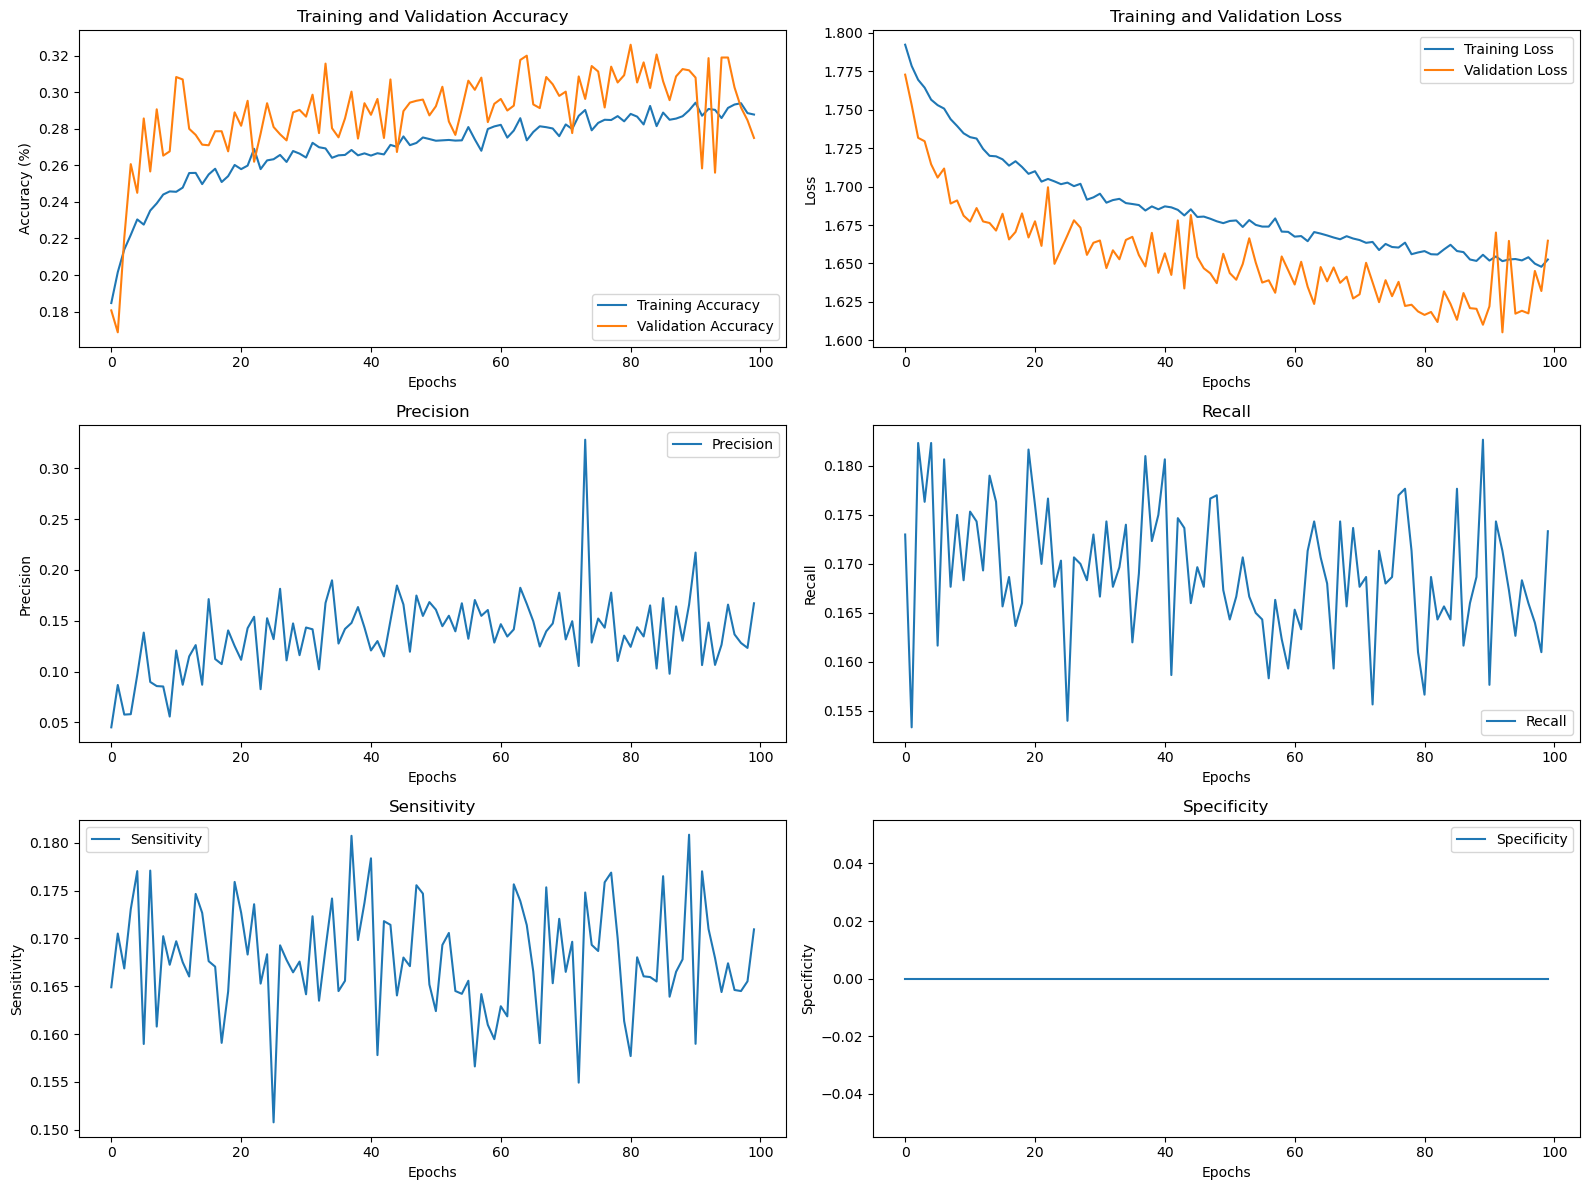

60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2747 - loss: 1.6692
Test Loss: 1.6648, Test Accuracy: 0.28%


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

# Define paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive 2"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model using pre-trained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpoint_efficientnetb3.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics (Precision, Recall, F1-Score, ROC AUC)
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on the validation set
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        # Binarize the labels for each class (One-vs-Rest)
        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        # Calculate Precision, Recall, F1-Score, and ROC AUC
        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        # Confusion Matrix for Sensitivity and Specificity
        cm = confusion_matrix(val_labels, val_preds)
        TN = np.diag(cm).sum() - np.trace(cm)
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        specificity = np.mean(TN / (TN + FP + np.finfo(float).eps))
        sensitivity = np.mean(TP / (TP + FN + np.finfo(float).eps))

        # Log the metrics
        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        # Save metrics for plotting later
        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list, self.sensitivity_list, self.specificity_list = [], [], [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)
        self.sensitivity_list.append(sensitivity)
        self.specificity_list.append(specificity)

# Initialize the custom metrics callback
metrics_callback = MetricsCallback()

# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]
)

# Save the final model
model.save('best_model_efficientnetb3.h5')

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(16, 12))

# Accuracy Plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Plot
plt.subplot(3, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Plot
plt.subplot(3, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Sensitivity Plot
plt.subplot(3, 2, 5)
plt.plot(metrics_callback.sensitivity_list, label='Sensitivity')
plt.title('Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()

# Specificity Plot
plt.subplot(3, 2, 6)
plt.plot(metrics_callback.specificity_list, label='Specificity')
plt.title('Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 545ms/step
Epoch 1: Precision: 0.1714, Recall: 0.1717, F1-Score: 0.1715, ROC AUC: 0.5030, Sensitivity: 0.1702, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 263s 924ms/step - accuracy: 0.8011 - loss: 0.5580 - val_accuracy: 0.9073 - val_loss: 0.2482
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 669ms/step
Epoch 2: Precision: 0.1718, Recall: 0.1723, F1-Score: 0.1718, ROC AUC: 0.5034, Sensitivity: 0.1707, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.9053 - loss: 0.2655 - val_accuracy: 0.9120 - val_loss: 0.2325
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 707ms/step
Epoch 3: Precision: 0.1674, Recall: 0.1677, F1-Score: 0.1675, ROC AUC: 0.5006, Sensitivity: 0.1672, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.9240 - loss: 0.2188 - val_accuracy: 0.9097 - val_loss: 0.2295
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 533ms/step
Epoch 4: Precision: 0.1903, Recall: 0.1907, F1-Score: 0.1901, ROC AUC: 0.5144, 

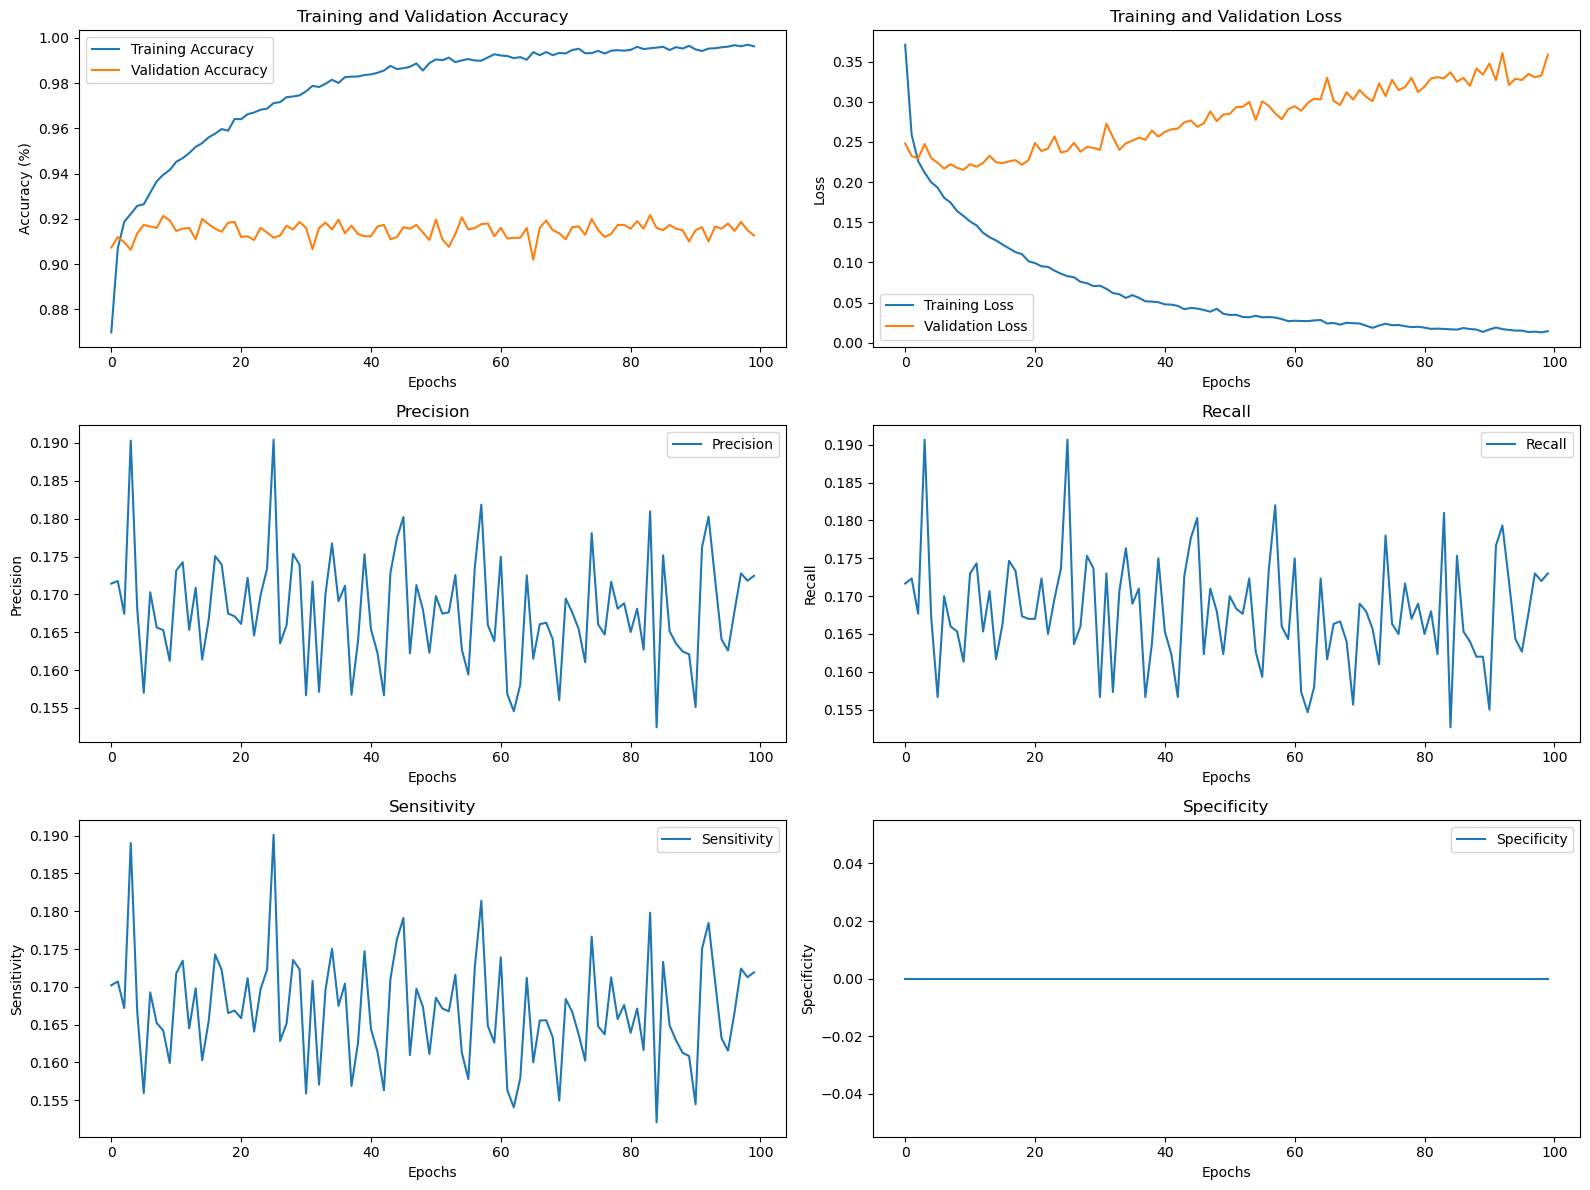

60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.8971 - loss: 0.4182
Test Loss: 0.3587, Test Accuracy: 0.91%


In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import label_binarize

# Define paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive 2"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model using pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpoint_mobilenetv2.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics (Precision, Recall, F1-Score, ROC AUC, Sensitivity, Specificity)
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on the validation set
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        # Binarize the labels for each class (One-vs-Rest)
        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        # Calculate Precision, Recall, F1-Score, and ROC AUC
        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        # Confusion Matrix for Sensitivity and Specificity
        cm = confusion_matrix(val_labels, val_preds)
        TN = np.diag(cm).sum() - np.trace(cm)
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        specificity = np.mean(TN / (TN + FP + np.finfo(float).eps))
        sensitivity = np.mean(TP / (TP + FN + np.finfo(float).eps))

        # Log the metrics
        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        # Save metrics for plotting later
        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list, self.sensitivity_list, self.specificity_list = [], [], [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)
        self.sensitivity_list.append(sensitivity)
        self.specificity_list.append(specificity)

# Initialize the custom metrics callback
metrics_callback = MetricsCallback()

# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]
)

# Save the final model
model.save('best_model_mobilenetv2.h5')

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(16, 12))

# Accuracy Plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Plot
plt.subplot(3, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Plot
plt.subplot(3, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Sensitivity Plot
plt.subplot(3, 2, 5)
plt.plot(metrics_callback.sensitivity_list, label='Sensitivity')
plt.title('Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()

# Specificity Plot
plt.subplot(3, 2, 6)
plt.plot(metrics_callback.specificity_list, label='Specificity')
plt.title('Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 427ms/step
Epoch 1: Precision: 0.1356, Recall: 0.1673, F1-Score: 0.1296, ROC AUC: 0.5004, Sensitivity: 0.1676, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.3058 - loss: 1.5835 - val_accuracy: 0.4277 - val_loss: 1.2298
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 449ms/step
Epoch 2: Precision: 0.1675, Recall: 0.1647, F1-Score: 0.1532, ROC AUC: 0.4988, Sensitivity: 0.1663, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.4736 - loss: 1.2224 - val_accuracy: 0.4957 - val_loss: 1.1824
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step
Epoch 3: Precision: 0.1652, Recall: 0.1633, F1-Score: 0.1338, ROC AUC: 0.4980, Sensitivity: 0.1634, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.5016 - loss: 1.1659 - val_accuracy: 0.4947 - val_loss: 1.1718
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 421ms/step
Epoch 4: Precision: 0.1785, Recall: 0.1773, F1-Score: 0.1778, ROC AUC: 0.5064, Sen

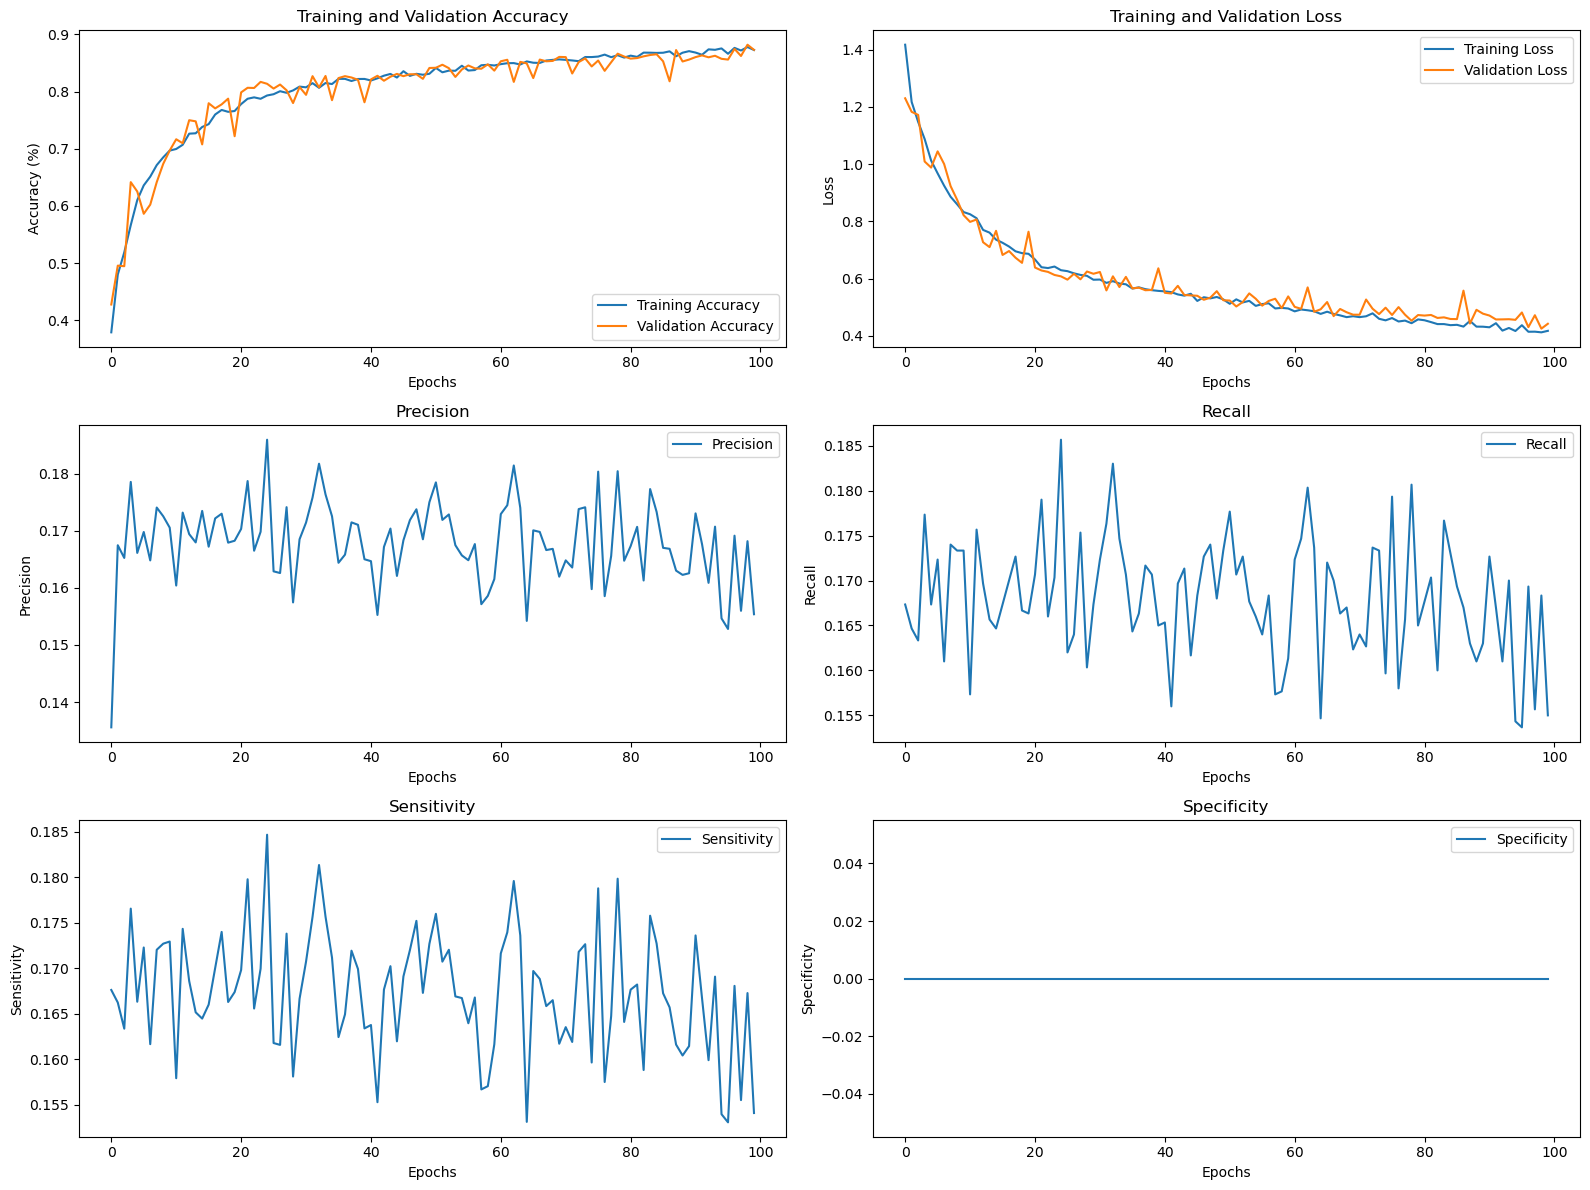

60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 419ms/step - accuracy: 0.8687 - loss: 0.4597
Test Loss: 0.4423, Test Accuracy: 0.87%


In [11]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import label_binarize

# Define paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive 2"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define SqueezeNet architecture
def SqueezeNet(input_shape=(224, 224, 3), num_classes=6):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(96, (7, 7), strides=2, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    # Fire modules
    def fire_module(x, squeeze, expand):
        x = layers.Conv2D(squeeze, (1, 1), activation='relu', padding='same')(x)
        left = layers.Conv2D(expand, (1, 1), activation='relu', padding='same')(x)
        right = layers.Conv2D(expand, (3, 3), activation='relu', padding='same')(x)
        return layers.Concatenate()([left, right])

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = fire_module(x, 64, 256)

    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)
    x = layers.GlobalAveragePooling2D()(x)

    return models.Model(inputs, x)

# Initialize the SqueezeNet model
model = SqueezeNet(num_classes=len(train_generator.class_indices))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpoint_squeezenet.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        cm = confusion_matrix(val_labels, val_preds)
        TN = np.diag(cm).sum() - np.trace(cm)
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        specificity = np.mean(TN / (TN + FP + np.finfo(float).eps))
        sensitivity = np.mean(TP / (TP + FN + np.finfo(float).eps))

        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list, self.sensitivity_list, self.specificity_list = [], [], [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)
        self.sensitivity_list.append(sensitivity)
        self.specificity_list.append(specificity)

metrics_callback = MetricsCallback()

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]
)

# Save the final model
model.save('best_model_squeezenet.h5')

# Plotting
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(metrics_callback.sensitivity_list, label='Sensitivity')
plt.title('Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(metrics_callback.specificity_list, label='Specificity')
plt.title('Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")